In [1]:
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.lens_pop import LensPop
import numpy as np
import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
from slsim.Sources.QuasarCatalog.quasar_pop import QuasarRate
import corner
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from slsim.Sources.galaxy_catalog import GalaxyCatalog
from tqdm import tqdm
from slsim.Plots.lens_plots import LensingPlots
from slsim.image_simulation import (
    point_source_coordinate_properties,
    lens_image_series,
    rgb_image_from_image_list,
)
from slsim.Plots.plot_functions import create_image_montage_from_image_list

/home/paras/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/paras/repos/self/slsim/slsim/Plots/lens_plots.py:5: UserWarning: If you want to simulate images with Roman filters, please install the galsim module.
Note that this module is not supported on Windows
  from slsim.roman_image_simulation import simulate_roman_image


## Lensed quasar population

This notebook shows how to simulate lensed quasar population.

In [2]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# define a sky area
galaxy_sky_area = Quantity(value=.5, unit="deg2")
quasar_sky_area = Quantity(value=.5, unit="deg2")
full_sky_area = Quantity(value=.5, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition
# to the skypy config
# file)
kwargs_deflector_cut = {"band": "i", "band_max": 30, "z_min": 0.01, "z_max": 5}
kwargs_source_cut = {"z_min": 0.001, "z_max": 5.0}

In [3]:
# generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None,
    sky_area=galaxy_sky_area,
    filters=None,
)

In [4]:
# Initiate deflector popiulation class
lens_galaxies = deflectors.AllLensGalaxies(
    red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=galaxy_sky_area,
)

/home/paras/repos/self/slsim/slsim/Deflectors/all_lens_galaxies.py:54: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  red_galaxy_list = catalog_with_angular_size_in_arcsec(
/home/paras/repos/self/slsim/slsim/Deflectors/all_lens_galaxies.py:57: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  blue_galaxy_list = catalog_with_angular_size_in_arcsec(


In [5]:
# Initiate QuasarRate class to generate quasar sample.
quasar_class = QuasarRate(
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    noise=True,
    redshifts=np.linspace(0.001, 5.01, 100),  # these redshifts are provided
    # to match general slsim redshift range in skypy pipeline.
)
quasar_source = quasar_class.quasar_sample(m_min=15, m_max=30, host_galaxy=False)
quasar_source_plus_galaxy = quasar_class.quasar_sample(m_min=15, m_max=30, host_galaxy=True)

Matching quasars with host galaxies:  44%|████▍     | 2323/5266 [02:01<02:34, 19.02it/s]/home/paras/repos/self/slsim/slsim/Sources/QuasarCatalog/quasar_host_match.py:120: RuntimeWarning: divide by zero encountered in log10
  M_bol = M_bol_sun - 2.5 * np.log10(L_bol)  # L_sun
Matching quasars with host galaxies: 100%|██████████| 5266/5266 [04:34<00:00, 19.17it/s]


In [6]:
quasar_source

z,M_i,ps_mag_i
float64,float64,float64
2.6733058817920896,-16.218873196411426,29.63721973347855
2.2139785400955954,-18.19730033597976,27.218358706149562
1.0334680339650517,-17.474612646390035,26.145548659642376
1.0333885180302627,-18.370712573019375,25.249321613333606
0.6264251798959442,-15.306141385453081,27.140853067364645
3.3480854766202355,-16.96241661170544,29.426563840050825
2.2212931759066845,-17.197635167740042,28.228090475763874
2.580820370677798,-19.23062116181671,26.583576606604105
0.37566450383333944,-15.543179353833185,25.781867373237915


In [7]:
quasar_source_plus_galaxy

z,M_i,ps_mag_i,M,coeff,ellipticity,physical_size,stellar_mass,angular_size,mag_g,mag_r,mag_i,mag_z,mag_y,vel_disp
,,,,,,kpc,,rad,,,,,,
float64,float64,float64,float64,float64[5],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2.6733058817920896,-16.218873196411426,29.63721973347855,-22.77188422926822,0.3722757632725142 .. 0.01530234940808711,0.18093875438389645,15.037528536590525,492657567047.06067,9.163873778662262e-06,23.72782226308272,23.70376626271169,23.592445375855895,23.60803947250352,23.567328813548336,404.8743967295673
2.2139785400955954,-18.19730033597976,27.218358706149562,-16.39221716484888,0.05669636200602604 .. 0.014944646476920415,0.04647073020240098,0.725918576380084,783778326.9837624,4.2629141842605593e-07,29.8193690121354,29.712419526997476,29.688443468256846,29.65453935543246,29.51646003598064,41.245303895736754
1.0334680339650517,-17.474612646390035,26.145548659642376,-16.737924708119245,0.24853185417129875 .. 0.018644167860895303,0.5132245027671669,0.8360938397703651,1030537385.009848,5.059413067769246e-07,28.21560914377456,27.820578011763747,27.192187150430616,26.62102242651059,26.38530936536632,42.19906882082833
1.0333885180302627,-18.370712573019375,25.249321613333606,-16.890431281770965,0.2949631232763277 .. 0.05163923150179843,0.2756587184662665,0.8092624383621055,1571437635.6558967,4.834274255707397e-07,27.72450297542724,27.443298657374154,27.14179810682634,26.66242953500338,26.432133995383484,43.81516266185198
0.6264251798959442,-15.306141385453081,27.140853067364645,-18.79661363560886,0.05963609566693758 .. 0.03906408282336508,0.34194821651522367,1.4532889800438074,9124661982.143557,1.0658591738981133e-06,24.61452653398772,23.78742782979755,23.180953624623797,22.967159515278723,22.78123486098366,97.48733275047229
3.3480854766202355,-16.96241661170544,29.426563840050825,-18.385170731355,0.0883292588051772 .. 0.051374506616391584,0.7012902436934908,2.058985434473064,3071433880.92588,1.345141662238937e-06,29.16028419253194,28.863531723235333,28.768738522704275,28.675516276638675,28.593995553523683,62.85892928048517
2.2212931759066845,-17.197635167740042,28.228090475763874,-17.171342243511226,0.4167734263408643 .. 0.15270449895510912,0.3920096677082785,1.2922465741467548,963066861.8618158,7.594256836309866e-07,29.929814652150995,29.58483098928499,29.340206110883827,29.04438092962082,28.747610739241743,41.96311740857687
2.580820370677798,-19.23062116181671,26.583576606604105,-21.041515400636012,0.32903497562575346 .. 0.02306212473931999,0.2691325686599165,2.7701871729247722,24245761119.99365,1.6706657614101771e-06,26.09107187815014,25.91449605253017,25.721807147926455,25.768309075869034,25.608790566402,132.9604625440357


In [8]:
# galaxy_catalog = GalaxyCatalog(
#                     cosmo=quasar_class.cosmo,
#                     # skypy_config=quasar_class.skypy_config,
#                     skypy_config=None,
#                     sky_area=quasar_class.sky_area,
#                 )
# host_galaxy_catalog = galaxy_catalog.galaxy_catalog()
# host_galaxy_catalog

In [9]:
# Prepare dictionary of agn variability kwargs
variable_agn_kwarg_dict = {
    "length_of_light_curve": 500,
    "time_resolution": 1,
    "log_breakpoint_frequency": 1 / 20,
    "low_frequency_slope": 1,
    "high_frequency_slope": 3,
    "standard_deviation": 0.9,
}

kwargs_quasar = {
    "variability_model": "light_curve",
    "kwargs_variability": {"agn_lightcurve", "i", "r", "g"},
    "agn_driving_variability_model": "bending_power_law",
    "agn_driving_kwargs_variability": variable_agn_kwarg_dict,
    "lightcurve_time": np.linspace(0, 1000, 500),
}

In [10]:
# Initiate source population class.
source_quasar = sources.PointSources(
    quasar_source,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    list_type = "astropy_table",
    # catalog_type="skypy",
    pointsource_type = "quasar",
    **kwargs_quasar,
)

source_quasar_plus_galaxies = sources.PointPlusExtendedSources(
    point_plus_extended_sources_list=quasar_source_plus_galaxy,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    list_type = "astropy_table",
    catalog_type="skypy",
    pointsource_type = "quasar",
    extendedsource_type= "single_sersic",
    **kwargs_quasar,
)

In [11]:
# Initiate LensPop class to generate lensed quasar pop. We simulate lens pop in 500
# deg^2. If you want to simulate in larger sky, change sky area to your requirement.
quasar_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_quasar,
    cosmo=cosmo,
    sky_area=full_sky_area,
)

quasar_plus_galaxies_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_quasar_plus_galaxies,
    cosmo=cosmo,
    sky_area=full_sky_area,
)

## Plot lenses

In [19]:
# make some cuts in the image separations and limited magnitudes of the arc
kwargs_lens_cut_plot = {
    "min_image_separation": 4,
    "max_image_separation": 30,
    "mag_arc_limit": {"g": 23, "r": 23, "i": 23},
}

quasar_plot = LensingPlots(quasar_lens_pop, num_pix=64, coadd_years=10)
quasar_plus_galaxies_plot = LensingPlots(quasar_plus_galaxies_lens_pop, num_pix=64, coadd_years=10)

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is n

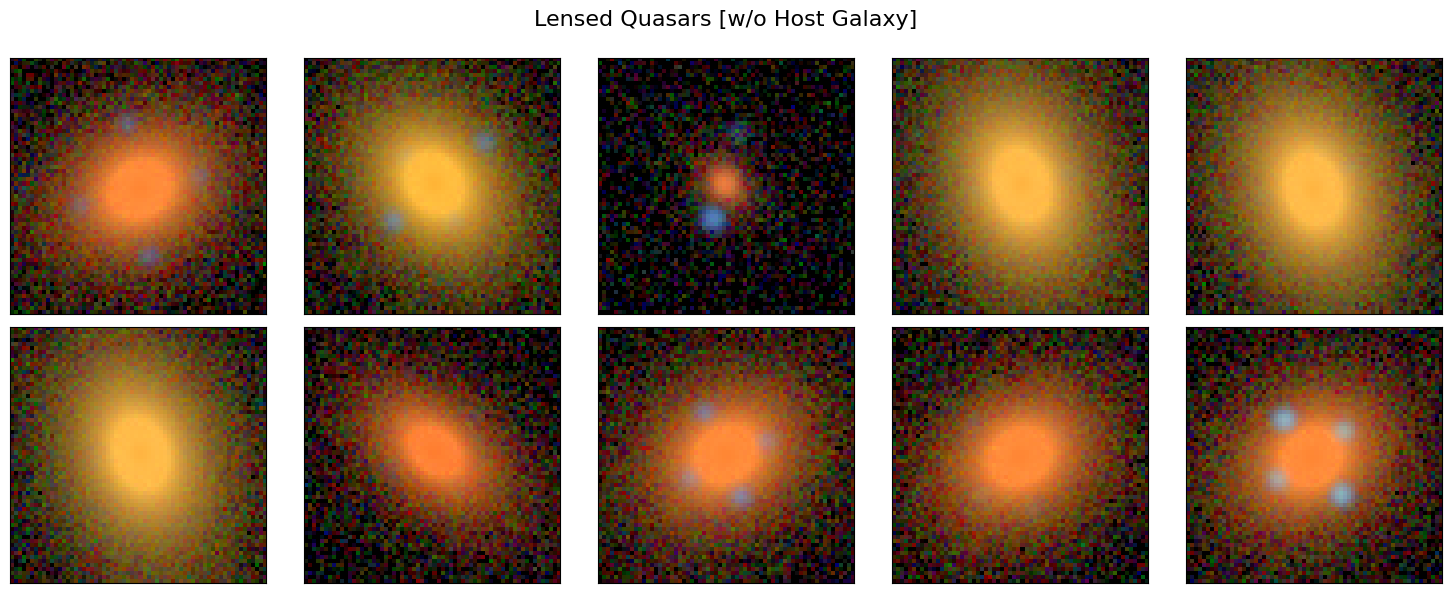

In [20]:
# generate montage indicating which bands are used for the rgb color image
fig, axes = quasar_plot.plot_montage(
    rgb_band_list=["i", "r", "g"],
    add_noise=True,
    n_horizont=5,
    n_vertical=2,
    kwargs_lens_cut=kwargs_lens_cut_plot,
)
fig.suptitle("Lensed Quasars [w/o Host Galaxy]", fontsize=16)
fig.subplots_adjust(top=0.9)
plt.show()

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is n

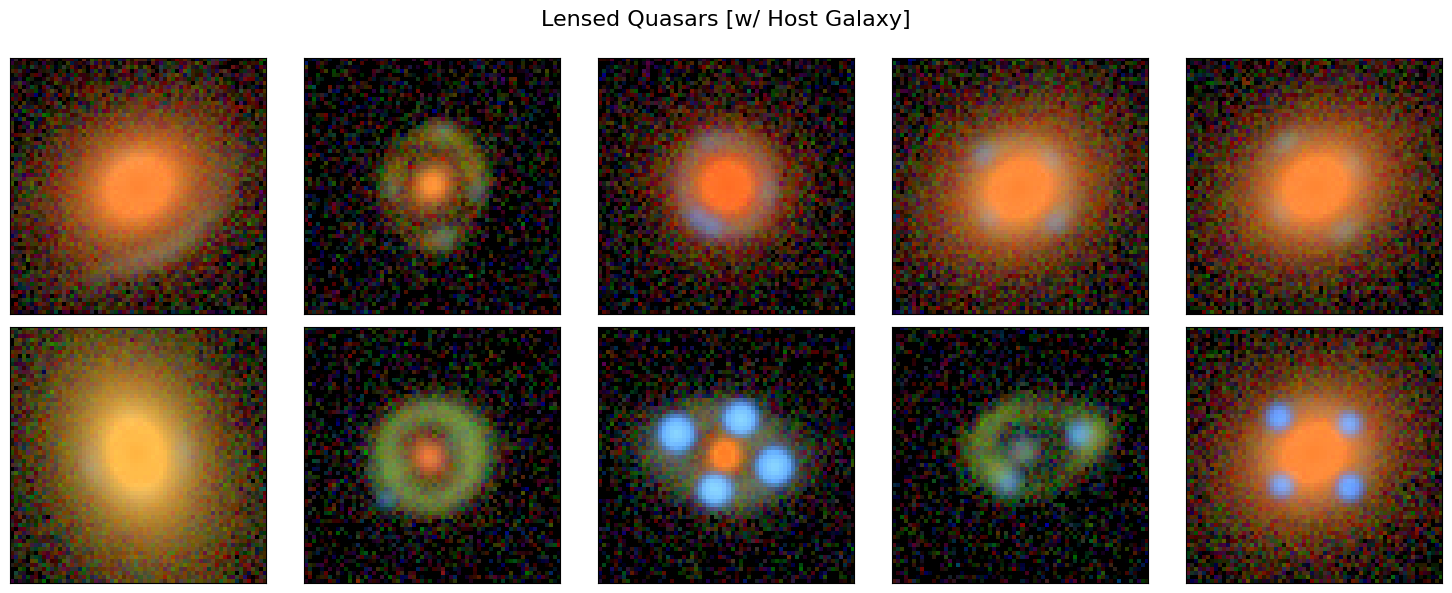

In [21]:
# generate montage indicating which bands are used for the rgb color image
fig, axes = quasar_plus_galaxies_plot.plot_montage(
    rgb_band_list=["i", "r", "g"],
    add_noise=True,
    n_horizont=5,
    n_vertical=2,
    kwargs_lens_cut=kwargs_lens_cut_plot,
)
fig.suptitle("Lensed Quasars [w/ Host Galaxy]", fontsize=16)
fig.subplots_adjust(top=0.9)
plt.show()